In [41]:
import numpy as np

# 定义系数矩阵 A 和常数向量 b
A = np.array([[1, 2, 1], [2, -1, 3], [3, 1, 2]])
b = np.array([7, 7, 18])

# 求解线性方程组
solution = np.linalg.solve(A, b)
x, y, z = solution

# 输出
print(f"方程组的解为：\n  x = {x:.2f}\n  y = {y:.2f}\n  z = {z:.2f}")
# 验证结果

ver = np.allclose(np.dot(A, solution), b)
print("验证:结果" + "正确" if ver else "不正确")


方程组的解为：
  x = 7.00
  y = 1.00
  z = -2.00
验证:结果正确


In [ ]:
import numpy as np

# 定义系数矩阵 A 和常数向量 b
A = np.array([[4, 3, 5], [2, 6, 4], [5, 2, 7]])
b = np.array([12.8, 14.0, 15.5])

# 求解线性方程组
solution = np.linalg.solve(A, b)
C, S, G = solution

# 输出单价
print(f"材料单价（万元/吨）：\n  水泥 (C) = {C:.2f}\n  钢筋 (S) = {S:.2f}\n  砂石 (G) = {G:.2f}")

# 验证工地 4 的采购计划
plan4 = np.array([3, 4, 6])  # 采购量
actual_cost = np.dot(plan4, solution)  # 计算实际成本
predict_cost = 13.0#预算13万
print(f"\n工地 4 的采购计划：")
print(f"  实际成本 = {actual_cost:.2f} 万元")
print(f"  预算 = {predict_cost:.2f} 万元")

# 判断实际成本是否超过预算成本
judge = actual_cost < predict_cost
output = f"  综上所述，预算{predict_cost:.2f} {'>' if judge else '<'} 实际成本{actual_cost:.2f}\n计划"
output += "合理" if  judge else "不合理"

print(output)

材料单价（万元/吨）：
  水泥 (C) = 0.09
  钢筋 (S) = 1.08
  砂石 (G) = 1.84

工地 4 的采购计划：
  实际成本 = 15.62 万元
  预算 = 13.00 万元
  综上所述，预算13.00 < 实际成本15.62
计划不合理


In [35]:
import pandas as pd

column_names = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv('u.data', sep='\t', names=column_names)

# 构建评分矩阵：行是用户ID，列是电影ID
ratings_matrix = data.pivot_table(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix  # 不填充


# 保存为 CSV 文件
ratings_matrix.to_csv('评分.csv', float_format='%.2f')
print(f"共 {ratings_matrix.shape[0]} 个用户，{ratings_matrix.shape[1]} 部电影。")


共 943 个用户，1682 部电影。


In [4]:
import numpy as np
from numpy import linalg as la
import pandas as pd

def loadExData():
    # 读取 CSV 文件：第一行为表头，第一列为用户ID，将缺失评分填充为0
    data = pd.read_csv("评分.csv", sep=",", header=0, index_col=0)
    return data.fillna(0).astype(np.float64).values

def ecludSim(X, Y):
    return 1.0 / (1.0 + la.norm(X - Y))

def pearsSim(X, Y):
    if len(X) < 3:
        return 1.0
    return 0.5 + 0.5 * np.corrcoef(X, Y, rowvar=1)[0][1]

def cosSim(X, Y):
    return 0.5 + 0.5 * (float(X.dot(Y.T)) / (la.norm(X) * la.norm(Y)))

def SigmaPct(sigma, percentage):
    sum_sigma = sum(sigma ** 2)
    threshold = sum_sigma * percentage
    total, k = 0, 0
    for val in sigma:
        total += val ** 2
        k += 1
        if total >= threshold:
            print("k值选择为:",k)
            return k

def svd_item(data, percentage):
    U, s, V = la.svd(data)
    k = SigmaPct(s, percentage)
    Sigma = np.eye(k) * s[:k]
    FormedItems = data.T.dot(U[:, :k].dot(la.inv(Sigma)))
    return FormedItems

def svd_predict(data, user, simMeas, FormedItems, item, percentage):
    TotalSim, TotalRatSim = 0.0, 0.0
    for j in range(np.shape(data)[1]):
        Rating_user = data[user, j]
        if Rating_user != 0 and j != item:
            Similarity = simMeas(FormedItems[item, :], FormedItems[j, :])
            TotalSim += Similarity
            TotalRatSim += Similarity * Rating_user
    return 0 if TotalSim == 0 else TotalRatSim / TotalSim

def recommend(data, user, FormedItems, N, simMeas, percentage):
    unratedItems = np.array(np.nonzero(data[user, :] == 0))[0]
    if len(unratedItems) == 0:
        return "你已评价完所有物品"
    ScoresItem = []
    for item in unratedItems:
        estimatedScore = svd_predict(data, user, simMeas, FormedItems, item, percentage)
        ScoresItem.append((item, estimatedScore))
    ScoresItem = sorted(ScoresItem, key=lambda x: x[1], reverse=True)
    return ScoresItem[:N]

def recommend_predict():
    user_item = loadExData()
    percentage = 0.9   # 保留奇异值平方和的百分比
    user = 1           # 需要确保用户ID在数据范围内
    n = 5              # 推荐个数
    FormedItems = svd_item(user_item, percentage)

    def print_recommendation(title, sim_func):
        print(f"\n{title}")
        results = recommend(user_item, user, FormedItems, n, sim_func, percentage)
        if isinstance(results, str):
            print(results)
        else:
            for item_id, score in results:
                print(f"推荐书籍 ID：{item_id}（{score:.4f}）")
    print("推荐格式[书籍ID (xx相关系数)]")
    print_recommendation("基于余弦相似度：", cosSim)
    print_recommendation("基于欧氏距离：", ecludSim)
    print_recommendation("基于皮尔逊相关系数：", pearsSim)


recommend_predict()


k值选择为: 272
推荐格式[书籍ID (xx相关系数)]

基于余弦相似度：
推荐书籍 ID：1605（3.7281）
推荐书籍 ID：935（3.7278）
推荐书籍 ID：366（3.7275）
推荐书籍 ID：812（3.7261）
推荐书籍 ID：334（3.7260）

基于欧氏距离：
推荐书籍 ID：8（3.6901）
推荐书籍 ID：514（3.6899）
推荐书籍 ID：14（3.6895）
推荐书籍 ID：172（3.6893）
推荐书籍 ID：317（3.6893）

基于皮尔逊相关系数：
推荐书籍 ID：334（3.7275）
推荐书籍 ID：1605（3.7273）
推荐书籍 ID：366（3.7265）
推荐书籍 ID：935（3.7264）
推荐书籍 ID：1413（3.7264）


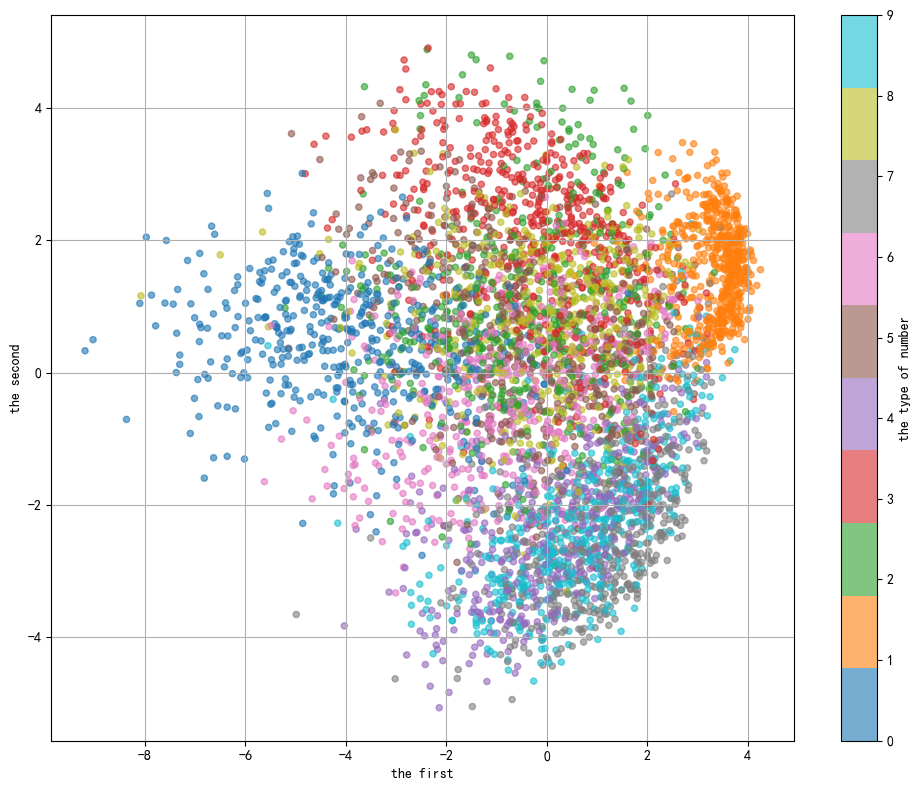

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载 MNIST 数据集
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)
X = X / 255.0  # 归一化

# 随机选取一部分样本
np.random.seed(42)
indices = np.random.choice(X.shape[0], size=5000, replace=False)
X_sample = X[indices]
y_sample = y[indices]

# 数据中心化
X_centered = X_sample - np.mean(X_sample, axis=0)

# SVD 实现 PCA
U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
V2 = Vt[:2, :]  # 前两个主成分方向

# 将数据投影到前两个主成分方向上
X_2D = np.dot(X_centered, V2.T)

# 可视化
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, label='the type of number')
plt.xlabel('the first')
plt.ylabel('the second')
plt.grid(True)
plt.tight_layout()
plt.show()
